# Damped Local Trend (DLT)

Here we will cover:

- DLT model structure
- DLT global trend configurations
- Adding regressors in DLT
- Other configurations

In [1]:
%matplotlib inline

import orbit
from orbit.models.dlt import DLTMAP
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.dataset import load_iclaims

In [2]:
assert orbit.__version__ == '1.0.12'

## Model Structure

**DLT** is one of the main exponential smoothing models we support in `orbit`.  Performance is benchmarked with M3 monthly, M4 weekly dataset and some Uber internal dataset [(Ng and Wang et al., 2020)](https://arxiv.org/abs/2004.08492).  The model is a fusion between the classical ETS [(Hyndman et. al., 2008)](http://www.exponentialsmoothing.net/home)) with some refinement leveraging ideas from Rlgt [(Smyl et al., 2019)](https://cran.r-project.org/web/packages/Rlgt/index.html). The model has a structural forecast equations as such

$$
\begin{align*}
y_t &=\mu_t + s_t + r_t +  \epsilon_t \\
\mu_t &=g_t + l_{t-1} +  \theta{b_{t-1}} \\
\epsilon_t  &~\sim \mathtt{Student}(\nu, 0, \sigma)\\
\sigma &~\sim  \mathtt{HalfCauchy}(0, \gamma_0)
\end{align*}
$$

with the update process as such 

$$
\begin{align*}
g_t &= D(t)\\
l_t &= \rho_l(y_t - g_{t} - s_t - r_t) + (1-\rho_l)(l_{t-1} + \theta b_{t-1})\\
b_t &=  \rho_b(l_t - l_{t-1}) + (1-\rho_b)\theta b_{t-1}\\
s_{t+m} &=  \rho_s(y_t - l_t - r_t) + (1-\rho_s)s_t\\
r_t &=  \Sigma_{j}\beta_j x_{jt}
\end{align*}
$$

One important point is here that using $y_t$ as a log-transformed response usually yield better result, especially we can interpret such log-transformed model as a *multiplicative form* of the original model.  Besides, there are two new additional components compared to the classical damped ETS model:

1. $D(t)$ as the deterministic trend process
2. $r$ as the regression component with $x$ as the regressors

In [3]:
# load log-transformed data
df = load_iclaims()
test_size = 52 * 3
train_df = df[:-test_size]
test_df = df[-test_size:]
response_col = 'claims'
date_col = 'week'

## Global Trend Configurations

There are a few choices of $D(t)$ configured by `global_trend_option`:

1. `loglinear`
2. `linear`
3. `flat`
4. `logistic`    

To show the difference among these options. We project the predictions in the charts below. Note that the default is set to `linear` which we find a better fit for a log-transformed model.  Such default is also used in the benchmarking process mentioned previously.

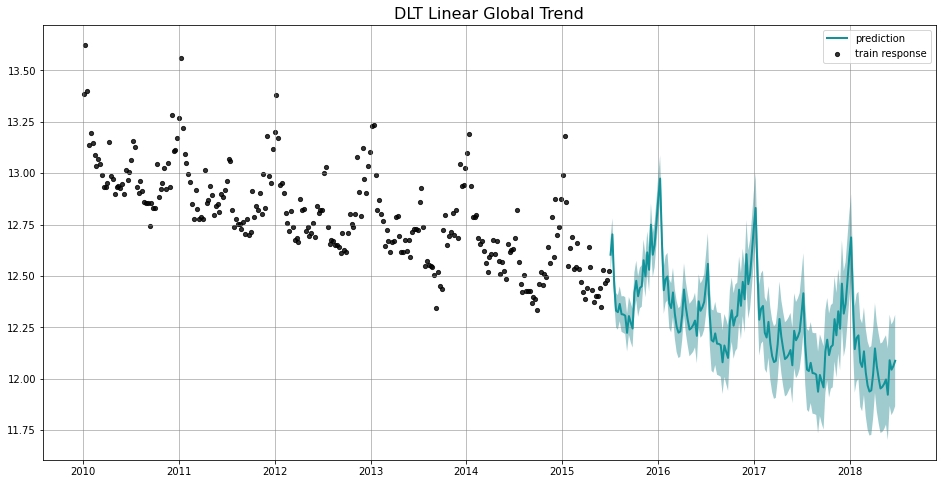

CPU times: user 1.4 s, sys: 363 ms, total: 1.76 s
Wall time: 2.02 s


In [4]:
%%time
# linear global trend
dlt = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

dlt.fit(train_df)
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col,  title='DLT Linear Global Trend')

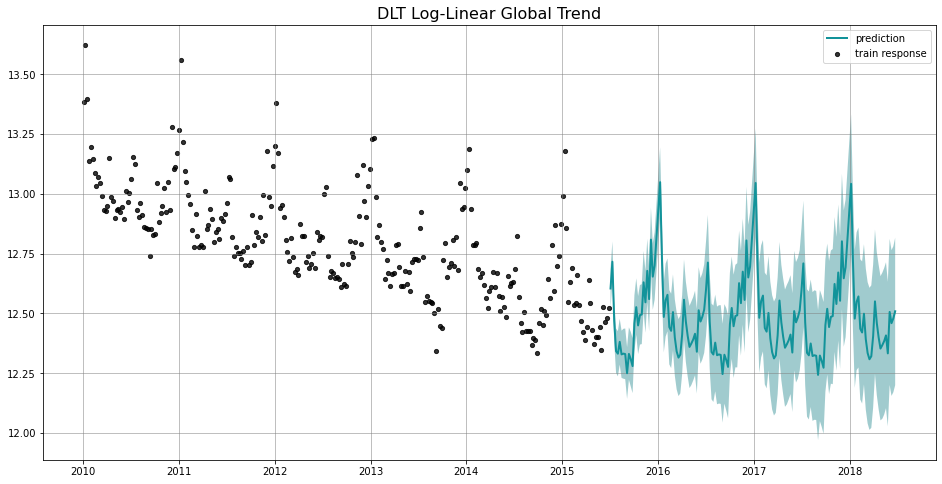

CPU times: user 1.29 s, sys: 292 ms, total: 1.58 s
Wall time: 1.43 s


In [5]:
%%time
# log-linear global trend
dlt = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    global_trend_option='loglinear'
)

dlt.fit(train_df)
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col,  title='DLT Log-Linear Global Trend')

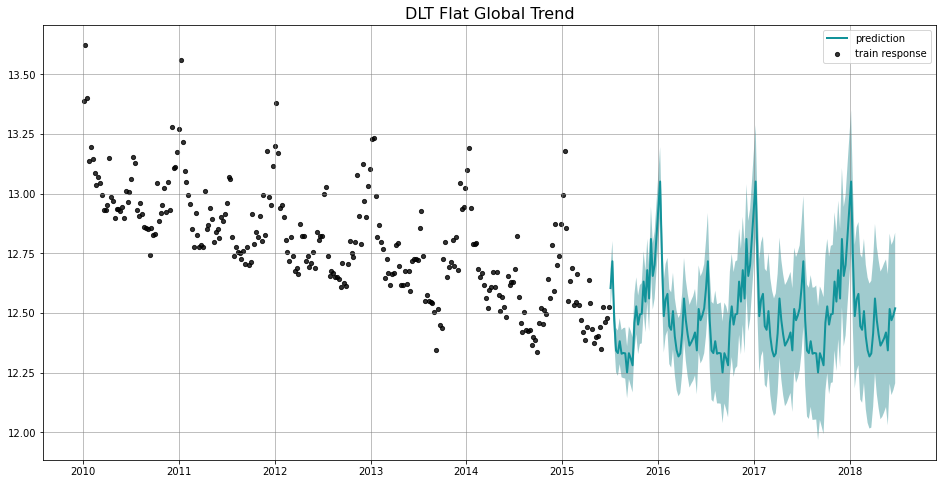

CPU times: user 1.22 s, sys: 288 ms, total: 1.51 s
Wall time: 1.36 s


In [6]:
%%time
# log-linear global trend
dlt = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    global_trend_option='flat'
)

dlt.fit(train_df)
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col,  title='DLT Flat Global Trend')

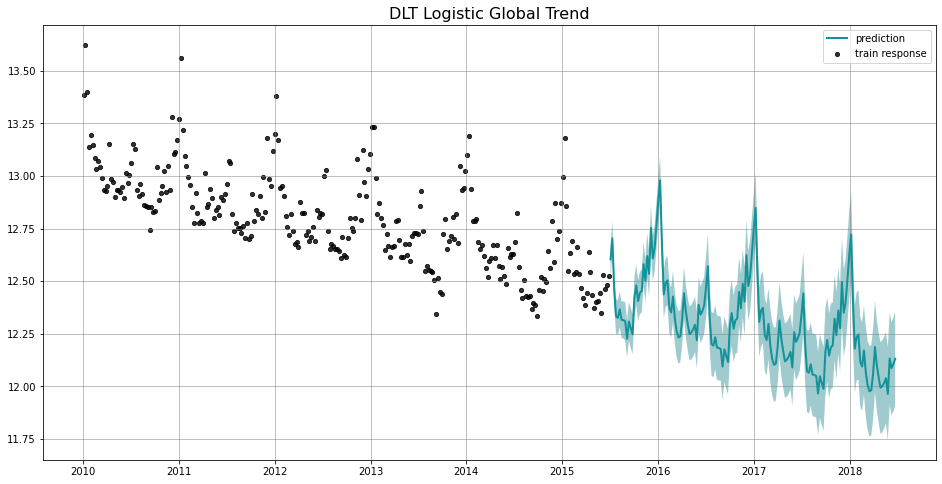

CPU times: user 1.36 s, sys: 300 ms, total: 1.66 s
Wall time: 1.54 s


In [7]:
%%time
# logistic global trend
dlt = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    global_trend_option='logistic'
)

dlt.fit(train_df)
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col,  title='DLT Logistic Global Trend')

## Regression

You can also add regressor into the model by specifying `regressor_col`.  This serves the purpose of nowcasting or forecasting when exogenous regressors are known such as events and holidays.  Without losing generality, the interface is set to be

$$\beta_j ~\sim \mathcal{N}(\mu_j, \sigma_j^2)$$

where $\mu_j = 0$  and $\sigma_j = 1$ by default as a non-informative prior. These two parameters are set by the arguments `regressor_beta_prior` and `regressor_sigma_prior` as a list.  For example,

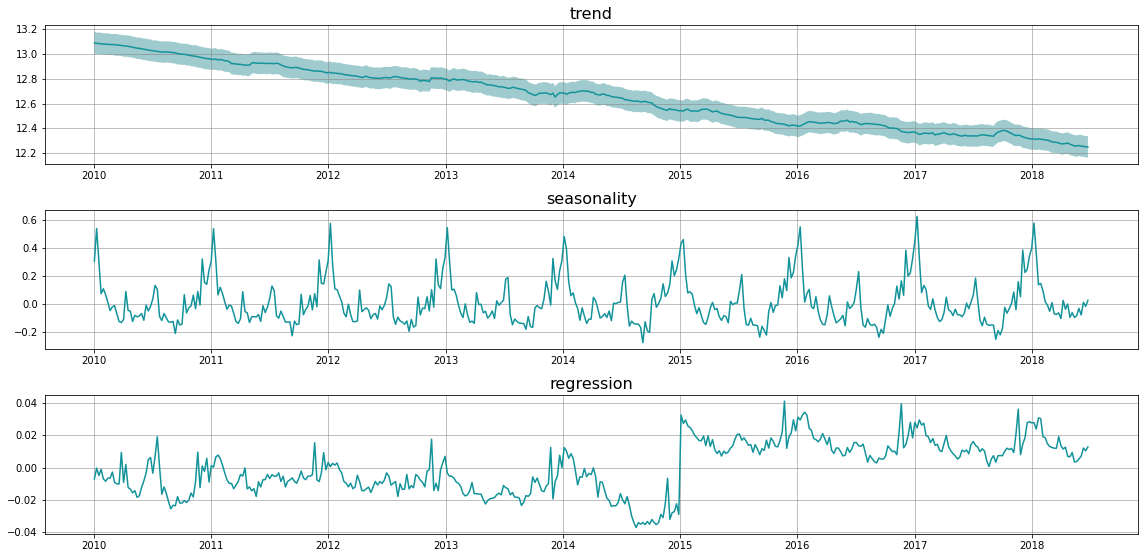

In [10]:
dlt = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seed=8888,
    seasonality=52,
    regressor_col=['trend.unemploy', 'trend.filling'],
    regressor_beta_prior=[0.1, 0.3],
    regressor_sigma_prior=[0.5, 2.0],
)

dlt.fit(df)
predicted_df = dlt.predict(df, decompose=True)
_ = plot_predicted_components(predicted_df, date_col)

There are much more configurations on regression such as the regressor signs and penalty type.  They will be discussed in later section.

## Other Configurations

Just like other model, there are full Bayesian version and aggregated posteriors version for *DLT* named `DLTAggregated` and  `DLTFull`.  They are usually more robust in regression but may take longer time to train.  More details for each method are available in the docstrings and also here: https://uber.github.io/orbit/orbit.models.html#module-orbit.models.dlt